## **Compound V2 Risk Scoring Model**

In [1]:
# Install dependencies
!pip install pandas numpy scikit-learn matplotlib seaborn web3 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.5/587.5 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 69.0 MB/s eta 0:00:00


Unzipping the JSON files zip

In [10]:
!unzip "/content/compound_v2.zip" -d "/content/compound_data"

Archive:  /content/compound_v2.zip
  inflating: /content/compound_data/compoundV2_transactions_ethereum_chunk_91.json  
  inflating: /content/compound_data/compoundV2_transactions_ethereum_chunk_72.json  
  inflating: /content/compound_data/compoundV2_transactions_ethereum_chunk_80.json  
  inflating: /content/compound_data/compoundV2_transactions_ethereum_chunk_64.json  
  inflating: /content/compound_data/compoundV2_transactions_ethereum_chunk_86.json  
  inflating: /content/compound_data/compoundV2_transactions_ethereum_chunk_59.json  
  inflating: /content/compound_data/compoundV2_transactions_ethereum_chunk_79.json  
  inflating: /content/compound_data/compoundV2_transactions_ethereum_chunk_84.json  
  inflating: /content/compound_data/compoundV2_transactions_ethereum_chunk_76.json  
  inflating: /content/compound_data/compoundV2_transactions_ethereum_chunk_85.json  
  inflating: /content/compound_data/compoundV2_transactions_ethereum_chunk_55.json  
  inflating: /content/compound

In [2]:
# Import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from collections import defaultdict
from datetime import datetime
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Merging all the JSON files in the Combined V2 dataset into a single JSON file

In [12]:
#Concatenating all the JSONS
import os
import json
merged_data = []
folder_path = '/content/compound_data'
def get_final_json(path):
  # List all JSON files in the folder
  for filename in sorted(os.listdir(folder_path)):
      if filename.endswith('.json'):
          file_path = os.path.join(folder_path, filename)
          with open(file_path, 'r', encoding='utf-8') as f:
              data = json.load(f)
              if isinstance(data, list):
                  merged_data.extend(data)
              else:
                  merged_data.append(data)  # for non-list JSON
get_final_json(folder_path)

In [19]:
# output_file = os.path.join('/content/', 'merged_output.json')
# with open(output_file, 'w', encoding='utf-8') as f:
#     json.dump(merged_data, f, indent=2, ensure_ascii=False)

Viewing the individual key and its items to format the data as per our needs

In [17]:
merged_data[0]['deposits'][0]

{'account': {'id': '0x502cb8985b2c92a8d4bf309cdaa89de9be442708'},
 'amount': '10000000000000000',
 'amountUSD': '1.78010000000000014408',
 'asset': {'id': '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee',
  'symbol': 'ETH'},
 'hash': '0xa1b27194b198762eaa631564fea76008b363c157a1ccf9df5f1338b7c566fd3a',
 'id': '0xa1b27194b198762eaa631564fea76008b363c157a1ccf9df5f1338b7c566fd3a-69',
 'timestamp': '1557193282'}

### Fetching the 100 Wallets given to us in Wallet id.csv

In [20]:
# List of 100 wallet addresses
wallets = pd.read_excel('/content/Wallet id.xlsx')
# convert this into a list having all the wallet ids
wallets_list = wallets['wallet_id'].tolist()
wallets_list[0]

'0x0039f22efb07a647557c7c5d17854cfd6d489ef3'

## Formatting and creating a dictionary which can be converted to a dataframe and has the keys as Wallet ids and all their corresponding transaction details.

In [70]:
import json
import os

# Path to your folder with JSON files
folder_path = '/content/compound_data'

# Your list of wallet IDs
wallet_ids = wallets_list.copy()

# Set to lowercase for consistent comparison
wallet_ids = set(w.lower() for w in wallet_ids)

# Structure to store results per wallet
wallet_transactions = {wallet: [] for wallet in wallet_ids}

# Sections to search
sections = ['deposits', 'withdraws', 'borrows', 'repays', 'liquidates']

# Process each JSON file
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON: {filename}")
                continue

            for section in sections:
                for entry in data.get(section, []):
                    wallet_id = entry.get('account', {}).get('id', '').lower()
                    if wallet_id in wallet_ids:
                        wallet_transactions[wallet_id].append({
                            **entry,
                            "type": section
                        })

# with open('filtered_wallet_transactions.json', 'w', encoding='utf-8') as f:
#     json.dump(wallet_transactions, f, indent=2, ensure_ascii=False)

print("DONE")

DONE


In [30]:
wallet_transactions['0x0039f22efb07a647557c7c5d17854cfd6d489ef3'][0]

{'account': {'id': '0x0039f22efb07a647557c7c5d17854cfd6d489ef3'},
 'amount': '58449551636',
 'amountUSD': '58449.551636',
 'asset': {'id': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',
  'symbol': 'USDC'},
 'hash': '0x335d36e0c44c2497a688e8d336527c4de11bcd9775dd748d61da8d7f1d641a34',
 'id': '0x335d36e0c44c2497a688e8d336527c4de11bcd9775dd748d61da8d7f1d641a34-151',
 'timestamp': '1612506281',
 'type': 'withdraws'}

Converting the dict to a dataframe

In [35]:
# Convert wallet_transactions to DataFrame
def prepare_transaction_data(wallet_transactions):
    records = []
    for wallet_id, transactions in wallet_transactions.items():
        for tx in transactions:
            records.append({
                'userWallet': tx['account']['id'],
                'timestamp': int(tx['timestamp']),
                'amount_usd': float(tx['amountUSD']),
                'assetSymbol': tx['asset']['symbol'],
                'action': tx['type'].lower()
            })
    df = pd.DataFrame(records)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    return df

## Feature Engineering

In [36]:
def engineer_features(df):
    wallets = defaultdict(lambda: {
        'num_transactions': 0,
        'num_deposits': 0,
        'total_deposit_usd': 0.0,
        'num_borrows': 0,
        'total_borrow_usd': 0.0,
        'num_repays': 0,
        'total_repay_usd': 0.0,
        'num_liquidations': 0,
        'total_liquidation_usd': 0.0,
        'num_withdrawals': 0,
        'total_withdrawal_usd': 0.0,
        'unique_assets': set(),
        'time_span': 0,
        'borrow_to_deposit_ratio': 0.0,
        'repay_to_borrow_ratio': 0.0,
        'liquidation_to_borrow_ratio': 0.0
    })

    for _, row in df.iterrows():
        wallet = row['userWallet']
        action = row['action']
        amount_usd = row['amount_usd']
        asset = row['assetSymbol']
        timestamp = row['timestamp']

        wallets[wallet]['num_transactions'] += 1
        wallets[wallet]['unique_assets'].add(asset)

        if action == 'deposits':
            wallets[wallet]['num_deposits'] += 1
            wallets[wallet]['total_deposit_usd'] += amount_usd
        elif action == 'borrows':
            wallets[wallet]['num_borrows'] += 1
            wallets[wallet]['total_borrow_usd'] += amount_usd
        elif action == 'repays':
            wallets[wallet]['num_repays'] += 1
            wallets[wallet]['total_repay_usd'] += amount_usd
        elif action == 'withdraws':
            wallets[wallet]['num_withdrawals'] += 1
            wallets[wallet]['total_withdrawal_usd'] += amount_usd
        elif action == 'liquidates':
            wallets[wallet]['num_liquidations'] += 1
            wallets[wallet]['total_liquidation_usd'] += amount_usd

    # Compute derived features
    wallet_features = []
    for wallet, stats in wallets.items():
        stats['time_span'] = (df[df['userWallet'] == wallet]['timestamp'].max() -
                              df[df['userWallet'] == wallet]['timestamp'].min()).days
        stats['borrow_to_deposit_ratio'] = (stats['total_borrow_usd'] / stats['total_deposit_usd']
                                            if stats['total_deposit_usd'] > 0 else 0)
        stats['repay_to_borrow_ratio'] = (stats['total_repay_usd'] / stats['total_borrow_usd']
                                          if stats['total_borrow_usd'] > 0 else 0)
        stats['liquidation_to_borrow_ratio'] = (stats['total_liquidation_usd'] / stats['total_borrow_usd']
                                                if stats['total_borrow_usd'] > 0 else 0)
        stats['num_unique_assets'] = len(stats['unique_assets'])
        wallet_features.append({
            'wallet': wallet,
            **{k: v for k, v in stats.items() if k != 'unique_assets'}
        })

    return pd.DataFrame(wallet_features)

## Computing Risk Scores for the 100 wallets using Anomoly Forest and K-Means

In [79]:
# Risk Scoring Function
def compute_risk_scores(wallet_transactions):
    # Prepare data
    df = prepare_transaction_data(wallet_transactions)

    # Engineer features
    features_df = engineer_features(df)

    # Standardize features
    feature_columns = [col for col in features_df.columns if col != 'wallet']
    scaler = StandardScaler()
    X = scaler.fit_transform(features_df[feature_columns])

    # Step 4: Isolation Forest for anomaly detection
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    anomaly_labels = iso_forest.fit_predict(X)
    anomaly_scores = iso_forest.score_samples(X)  # Lower is more anomalous

    # Step 5: K-Means for non-anomalous wallets
    non_anomalous_mask = anomaly_labels == 1
    X_non_anomalous = X[non_anomalous_mask]
    kmeans = KMeans(n_clusters=5, random_state=42)
    cluster_labels = kmeans.fit_predict(X_non_anomalous)

    # Assign scores
    scores = pd.Series(index=features_df['wallet'], dtype=float)

    # Create ideal profile: max of positive features, min of negative features
    ideal_profile = np.array([max(features_df[col]) if col in [
        'num_deposits', 'total_deposit_usd', 'num_repays', 'total_repay_usd',
        'repay_to_borrow_ratio', 'num_unique_assets', 'time_span'
    ] else min(features_df[col]) for col in feature_columns])

    # Standardize the ideal profile
    ideal_profile = scaler.transform([ideal_profile])[0]

    non_anomalous_wallets = features_df['wallet'][non_anomalous_mask].reset_index(drop=True)
    X_non_anomalous_df = pd.DataFrame(X_non_anomalous, index=non_anomalous_wallets)

    # Compute Euclidean distances from each wallet to the ideal profile
    distances = X_non_anomalous_df.apply(lambda row: np.linalg.norm(row - ideal_profile), axis=1)

    # Normalize distances: lower = closer to ideal
    min_dist = distances.min()
    max_dist = distances.max()

    # Min-Max Normalisation
    normalized_distances = (distances - min_dist) / (max_dist - min_dist + 1e-6)  # avoid zero-division

    # Apply exponential decay to spread scores between 600 and 1000
    scaled_scores = 700 + 300 * np.exp(-3 * normalized_distances)

    # Assign scores to non-anomalous wallets
    for wallet, score in zip(non_anomalous_wallets, scaled_scores):
        scores[wallet] = round(score)

    # Assign scores to anomalous wallets
    for i, wallet in enumerate(features_df['wallet']):
        if anomaly_labels[i] == -1:
            score = max(0, 200 * (1 + anomaly_scores[i]))  # map to 0–200
            scores[wallet] = round(score)

    # Create output DataFrame
    scores_df = pd.DataFrame({'wallet': scores.index, 'risk_score': scores.values})
    # Visualize score distribution
    scores_df['anomaly'] = ['Anomalous' if lbl == -1 else 'Normal' for lbl in anomaly_labels]
    sns.histplot(data=scores_df, x='risk_score', hue='anomaly', bins=50, palette='Set2', multiple='stack')
    plt.title("Risk Scores by Anomaly Label")
    plt.xlabel("Risk Score")
    plt.ylabel("Wallet Count")
    plt.grid(True)
    plt.show()
    return scores_df

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


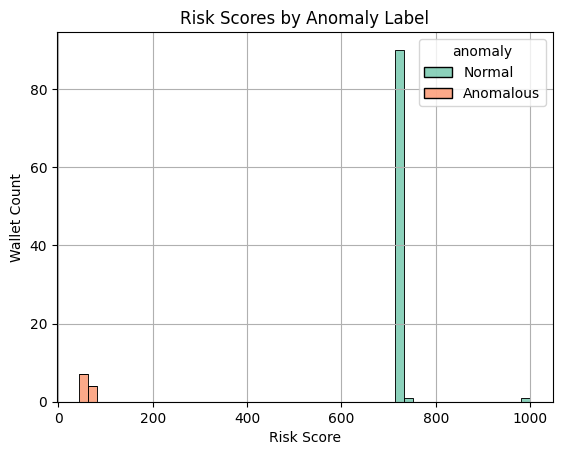

In [80]:
# Calling the function to fetch risk scores
scores_df = compute_risk_scores(wallet_transactions)

In [81]:
scores_df.head()

,wallet,risk_score,anomaly
0,0xfe5a05c0f8b24fca15a7306f6a4ebb7dcf2186ac,715.0,Normal
1,0x7de76a449cf60ea3e111ff18b28e516d89532152,715.0,Normal
2,0x96bb4447a02b95f1d1e85374cffd565eb22ed2f8,715.0,Normal
3,0x4c4d05fe859279c91b074429b5fc451182cec745,715.0,Normal
4,0x1656f1886c5ab634ac19568cd571bc72f385fdf7,54.0,Anomalous


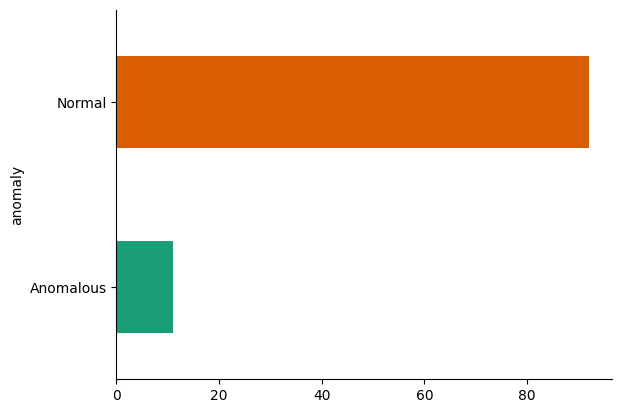

In [82]:
from matplotlib import pyplot as plt
import seaborn as sns
scores_df.groupby('anomaly').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## **Our Final Dataframe with Results**

In [83]:
df_final = scores_df.drop(columns=['anomaly'])
df_final.head()

,wallet,risk_score
0,0xfe5a05c0f8b24fca15a7306f6a4ebb7dcf2186ac,715.0
1,0x7de76a449cf60ea3e111ff18b28e516d89532152,715.0
2,0x96bb4447a02b95f1d1e85374cffd565eb22ed2f8,715.0
3,0x4c4d05fe859279c91b074429b5fc451182cec745,715.0
4,0x1656f1886c5ab634ac19568cd571bc72f385fdf7,54.0


In [67]:
# df_final.to_csv('risk_scores.csv', index=False)